In [1]:
#import modules

import torch
import kaolin as kal
import numpy as np
from PIL import Image

device = torch.device('cuda:0')

In [2]:
#@title get camera params from elevation, azimuth, radius
def get_camera_from_view(elev, azim, r=3.0):
    x = r * torch.cos(elev) * torch.cos(azim)
    y = r * torch.sin(elev)
    z = r * torch.cos(elev) * torch.sin(azim)

    pos = torch.tensor([x, y, z]).unsqueeze(0)
    look_at = -pos
    direction = torch.tensor([0.0, 1.0, 0.0]).unsqueeze(0)

    camera_proj = kal.render.camera.generate_transformation_matrix(pos, look_at, direction)
    return camera_proj

In [3]:
#Mesh class

class Mesh:
  def __init__(self, obj_path, is_color = True):
     mesh = kal.io.obj.import_mesh(obj_path, with_normals = True)
     self.vertices = mesh.vertices.to(device)
     self.faces = mesh.faces.to(device)
     self.vertex_normals = mesh.vertex_normals.to(device)
     self.is_color = is_color
     if is_color:
       self.color_attributes = torch.zeros(self.vertices.size()[0] // 2, self.vertices.size()[1])
     self.normalize_mesh()
    
  def normalize_mesh(self):
    if self.is_color:
      self.color_attributes = self.vertices[1::2]
      self.vertices = self.vertices[::2]
      
    center = self.vertices.mean(dim = 0)
    v = self.vertices - center
    scale = torch.norm(v, dim = 1).max()
    v /= scale
    self.vertices = v

In [4]:
#Render single image from Mesh
lights = torch.tensor([1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]).to(device)
camera_projection =kal.render.camera.generate_perspective_projection(np.pi / 3).to(device)
dim = (224, 224)
def render_single_view(mesh, elev=0, azim=0, show=False, lighting=True, background=None, radius=2,
                        return_mask=False):
    # if mesh is None:
    #     mesh = self._current_mesh
    verts = mesh.vertices
    faces = mesh.faces
    n_faces = faces.shape[0]
    
    if not mesh.is_color:
        face_attributes = torch.ones(1, n_faces, 3, 3).to(device) * 0.5
    else:
        face_attributes = kal.ops.mesh.index_vertices_by_faces(mesh.color_attributes.unsqueeze(0).to(device), mesh.faces.to(device))

    camera_transform = get_camera_from_view(torch.tensor(elev), torch.tensor(azim), r=radius).to(device)
    face_vertices_camera, face_vertices_image, face_normals = kal.render.mesh.prepare_vertices(
        mesh.vertices.to(device), mesh.faces.to(device), camera_projection, camera_transform=camera_transform)

    image_features, soft_mask, face_idx = kal.render.mesh.dibr_rasterization(
        dim[1], dim[0], face_vertices_camera[:, :, :, -1],
        face_vertices_image, face_attributes, face_normals[:, :, -1])


    image = torch.clamp(image_features, 0.0, 1.0)
    if lighting:
        image_normals = face_normals[:, face_idx].squeeze(0)
        image_lighting = kal.render.mesh.spherical_harmonic_lighting(image_normals, lights).unsqueeze(0)
        image = image * image_lighting.repeat(1, 3, 1, 1).permute(0, 2, 3, 1).to(device)
        image = torch.clamp(image, 0.0, 1.0)

    return image

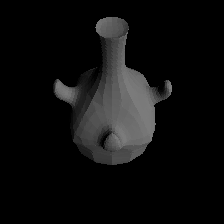

In [5]:
mesh = Mesh('./vase.obj', is_color=False)
image = render_single_view(mesh, elev = np.pi / 3)

Image.fromarray((image.squeeze(0).cpu().numpy() * 255.).astype('uint8'))

In [6]:
!pip install opencv-python

In [7]:
# # Part 1 
# # To Render multiple images/views and combine to form a video
import cv2
import os

# Loop over different azimuth values to get multiple views
# Azimuth Range 0-360 degrees or 0-2pi radians
azimuths = np.linspace(0, 2 * np.pi, num=100)

# Now loop over them
frames = []
for azim in azimuths:
  frame = render_single_view(mesh, elev = np.pi / 3, azim = np.float(azim))
  frame = Image.fromarray((frame.squeeze(0).cpu().numpy() * 255.).astype('uint8'))
  frame = np.array(frame) 
  # Convert RGB to BGR 
  frame = frame[:, :, ::-1].copy() 
  frames.append(frame)

# Now convert frames array to video using openCV
height, width, layers = frames[0].shape

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter("vase.mp4", fourcc, 30, (width, height))

for frame in frames:
    video.write(frame)

video.release()

# import imageio

# mesh = Mesh('vase.obj')
# azim_list = np.arange(0,2*np.pi, 0.01, dtype=np.float32)
# video = imageio.get_writer('camera_view.mp4', mode='I', fps=60, codec='libx264', bitrate='16M')
# for azim in azim_list:
#     image = render_single_view(mesh, elev = np.pi / 3, azim = azim)
#     video.append_data((image.squeeze(0).cpu().numpy() * 255.).astype('uint8'))
# video.close()



C:\Users\sanja\AppData\Local\Temp\ipykernel_14696\4176830269.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  frame = render_single_view(mesh, elev = np.pi / 3, azim = np.float(azim))


In [8]:
# Part 2 and 3
# To Render multiple images/views and combine to form a video
import cv2
import os
import pathlib
cur_dir = pathlib.Path().resolve()

# Loop over different azimuth values to get multiple views
# Azimuth Range 0-360 degrees or 0-2pi radians
azimuths = np.linspace(0, 2 * np.pi, num=100)

meshes = [mesh_name for mesh_name in os.listdir(cur_dir) if mesh_name.split(".")[-1] == "obj"]

for mesh in meshes:
  video_name = mesh.split(".")[0]
  if video_name == "vase":
      mesh = Mesh(mesh, is_color=False)
      print("reached")
  else:
      mesh = Mesh(mesh, is_color=True)
  # Now loop over them
  frames = []
  for azim in azimuths:
    frame = render_single_view(mesh, elev = 0, azim = float(azim))
    frame = Image.fromarray((frame.squeeze(0).cpu().numpy() * 255.).astype('uint8'))
    frame = np.array(frame) 
    # Convert RGB to BGR 
    frame = frame[:, :, ::-1].copy() 
    frames.append(frame)

  # Now convert frames array to video using openCV
  height, width, layers = frames[0].shape

  fourcc = cv2.VideoWriter_fourcc(*'mp4v')
  video = cv2.VideoWriter(video_name + "elev_0.mp4", fourcc, 30, (width, height))

  for frame in frames:
      video.write(frame)

  video.release()

reached
